In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import os
import process_observed_discharge as mQ
import glob
import pickle
from sklearn.metrics import r2_score

#### Model Evaluation
Compare Q quantiles of individuals models to observations

In [ ]:
with open("eval_stations_Q.pickle", "rb") as f:
    q_Obs = pickle.load(f)

#read validation stations (NSE>0
val_gdf = pd.read_csv('validation_stations_NSE_above_0.csv')

#Extract only stations in val_gdf
q_Obs = {k: v for k, v in q_Obs.items() if k in val_gdf['name'].values}

In [ ]:
#function to match frequency and resample to desired frequency
def match_frequency_and_resample(q_model: pd.Series, q_obs: pd.Series, obs_freq: str, resample_freq: str, station_id: str):
    """
    Match frequency of model and observed discharge time series.
    Resample both to the specified frequency if they differ.
    Parameters
    ----------
    q_model : pd.Series
        Modeled discharge time series (indexed by date).
    q_obs : pd.Series
        Observed discharge time series (indexed by date).
    obs_freq : str
        The frequency of observed data (e.g., 'D' for daily).
    resample_freq : str
        Resampling frequency (e.g., 'ME' for month-end).
    station_id : str
        Identifier for the station (for logging purposes).
    Returns
    -------
    pd.Series, pd.Series
        Resampled model and observed discharge time series.
    """
    #Check if both series have the same frequency and resample if not
    #Check if both series have the same frequency and resample if not
    #set indices to datetime if not already
    if not isinstance(q_model.index, pd.DatetimeIndex):
        q_model.index = pd.to_datetime(q_model.index)
    if not isinstance(q_obs.index, pd.DatetimeIndex):
        q_obs.index = pd.to_datetime(q_obs.index)

    #Enforce daily frequency for Observed data if not already
    q_obs = q_obs.asfreq(obs_freq)   # enforce daily frequency


    if not (pd.infer_freq(q_model.index) == pd.infer_freq(q_obs.index)):
        print(f"Station {station_id}: Data will be resampled to {resample_freq}.", end="\r")

        q_model_f = q_model.resample(resample_freq).mean()

        #resample observed data only if each month has at least 15 days of data
        q_obs_f = (
            q_obs
            .resample(resample_freq)
            .apply(lambda x: x.mean() if x.count() >= 20 else np.nan)
        )

    else:
        q_model_f = q_model
        q_obs_f = q_obs

    # Align and drop NaNs
    merged_Q = pd.concat([q_model_f, q_obs_f], axis=1)
    merged_Q.columns = ["q_model", "q_obs"]
    merged_Q = merged_Q.dropna()

    return merged_Q

#==================================================

#Function to extract per station flow quantiles

def extract_flow_quantiles(merged_Q: pd.Series, station_id: str):
    """
    Extract Q50 and Q90 for model vs. observed discharge at a given station.
    Returns a single-row DataFrame or None if too short.
    Parameters
    ----------
    merged_Q : pd.Series
        DataFrame with two columns: 'q_model' and 'q_obs', indexed by date.
    station_id : str
        Identifier for the station (for logging purposes).
    Returns
    -------
    pd.DataFrame or None
        DataFrame with columns ['station', 'q50_model', 'q90_model', 'q50_obs', 'q90_obs']
        or None if insufficient overlapping data.
    """
   
    # If DataFrame, reduce to first column
    if isinstance(merged_Q, pd.DataFrame):
        q_model = merged_Q.iloc[:, 0]
        q_obs = merged_Q.iloc[:, 1]

    if len(merged_Q) > 12:  # at least 2 years of overlapping data
        print(f"Station {station_id}: {len(merged_Q)} overlapping data points found.", end="\r")
        q50_model = np.nanpercentile(q_model.values, 50)
        q90_model = np.nanpercentile(q_model.values, 10)
        q50_obs   = np.nanpercentile(q_obs.values, 50)
        q90_obs   = np.nanpercentile(q_obs.values, 10)

        return pd.DataFrame(
            {
                "station": [station_id],
                "q50_model": [q50_model],
                "q90_model": [q90_model],
                "q50_obs": [q50_obs],
                "q90_obs": [q90_obs],
            }
        )
    else:
        print(f"Station {station_id}: skipped ({len(q_model)} points only).", end="\r")
        return None

In [ ]:
models = ["GFDL-ESM4", "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MRI-ESM2-0", "UKESM1-0-LL"]
canals = ['HACCOURT', 'Merendree_Afleidingskl Leie', 'Damme_Leopoldkl']

all_quantiles = {}

for model in models:
    sim_files = glob.glob(f"isimip_Q/{model}/Qrouted/*.csv")
    quantiles = []  # <-- collect per model

    for fpath in sim_files:
        station_name = os.path.splitext(os.path.basename(fpath))[0]

        if station_name not in q_Obs:
            continue  # skip stations without obs
        if station_name in canals:
            continue  # skip canal stations

        obs_Q = q_Obs[station_name]
        #set index to datetime if not already
        if not isinstance(obs_Q.index, pd.DatetimeIndex):
            obs_Q.index = pd.to_datetime(obs_Q.index)
        sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

        # Match frequency and resample to monthly
        q_merged = match_frequency_and_resample(sim_Q, obs_Q, 'D','ME', station_name)

        qn = extract_flow_quantiles(q_merged, station_name)
        if qn is not None:
            qn["model"] = model
            quantiles.append(qn)

    if quantiles:  # <-- use the correct list
        quantiles_df = pd.concat(quantiles, ignore_index=True)
    else:
        quantiles_df = pd.DataFrame()

    all_quantiles[model] = quantiles_df

In [ ]:
g_df = all_quantiles['UKESM1-0-LL']

#plt.scatter(g_df['q50_obs'], g_df['q50_model'], label='Q50', color='blue', alpha=0.6)

#1:1 line
max_val = max(g_df[['q50_obs', 'q50_model']].max().max(), g_df[['q90_obs', 'q90_model']].max().max())


#### Seasonal comparison of per-station Q

In [ ]:
season_map = {12:"DJF",1:"DJF",2:"DJF",
              3:"MAM",4:"MAM",5:"MAM",
              6:"JJA",7:"JJA",8:"JJA",
              9:"SON",10:"SON",11:"SON"}

all_seasonal = {}

for model in models:
    sim_files = glob.glob(f"isimip_Q/{model}/Qrouted/*.csv")
    model_season = []

    for fpath in sim_files:
        station_name = os.path.splitext(os.path.basename(fpath))[0]

        if station_name not in q_Obs or station_name in canals:
            continue

        obs_Q = q_Obs[station_name]
        sim_Q = pd.read_csv(fpath, index_col=0, parse_dates=True)

        # merge by date
        merged_df = pd.concat([sim_Q, obs_Q], axis=1, join="inner")
        merged_df.columns = ["q_model", "q_obs"]
        merged_df = merged_df.dropna()

        # add season label
        merged_df["season"] = merged_df.index.month.map(season_map)

        # seasonal climatology
        season_means = merged_df.groupby("season")[["q_model","q_obs"]].mean().reset_index()
        season_means["name"] = station_name
        season_means["model"] = model

        model_season.append(season_means)

    if model_season:
        all_seasonal[model] = pd.concat(model_season, ignore_index=True)


In [ ]:
model_seasons_df = pd.concat(all_seasonal.values(), ignore_index=True)
model_seasons_df = model_seasons_df[["name", "model", "season", "q_obs", "q_model"]]

In [ ]:
model_seasons_df[model_seasons_df['name'] == 'Wyompont']

In [ ]:
seasons = ["DJF", "MAM", "JJA", "SON"]
fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=120)

for ax, season in zip(axes.ravel(), seasons):
    obs_season = model_seasons_df.loc[model_seasons_df['season'] == season, 'q_obs']
    sim_season = model_seasons_df.loc[model_seasons_df['season'] == season, 'q_model']

    # remove NaNs
    valid = obs_season.notna() & sim_season.notna()
    obs_season = obs_season[valid]
    sim_season = sim_season[valid]

    if len(obs_season) == 0:
        ax.set_title(f"{season} (no data)")
        continue

    probs = np.linspace(0, 100, 101)
    q_obs = np.nanpercentile(obs_season, probs)
    q_sim = np.nanpercentile(sim_season, probs)

    # Compute R²
    r2_season = r2_score(q_obs, q_sim)

    # Plot points
    ax.scatter(q_obs, q_sim, alpha=0.6, s=30, c='dodgerblue')

    # 1:1 line
    lims = [min(q_obs.min(), q_sim.min()), max(q_obs.max(), q_sim.max())]
    ax.plot(lims, lims, 'r-', lw=0.7)

    ax.set_title(season)
    ax.text(0.05, 0.9, f'R² = {r2_season:.2f}', transform=ax.transAxes, fontsize=10, color='blue')

    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.grid(lw=0.5)

# Common x/y labels
for i, ax in enumerate(axes.ravel()):
    if i in [0, 2]:  # left column
        ax.set_ylabel("Simulated Quantiles")
    if i in [2, 3]:  # bottom row
        ax.set_xlabel("Observed Quantiles")

plt.tight_layout()
plt.show()


In [ ]:
seasons = ["DJF", "MAM", "JJA", "SON"]
colors  = {"DJF":"dodgerblue", "MAM":"dodgerblue", "JJA":"gray", "SON":"dodgerblue"}

plt.figure(figsize=(6,6))

for season in seasons:
    obs_season = model_seasons_df.loc[model_seasons_df['season'] == season, 'q_obs']
    sim_season = model_seasons_df.loc[model_seasons_df['season'] == season, 'q_model']

    valid = obs_season.notna() & sim_season.notna()
    obs_season = obs_season[valid]
    sim_season = sim_season[valid]

    if len(obs_season) == 0:
        continue

    # scatter
    plt.scatter(obs_season, sim_season, alpha=0.3, label=f"{season}", color=colors[season], s=30)

# 1:1 reference line
lims = [
    min(model_seasons_df['q_obs'].min(), model_seasons_df['q_model'].min()),
    max(model_seasons_df['q_obs'].max(), model_seasons_df['q_model'].max())
]
plt.plot(lims, lims, 'r-', lw=1)
plt.xlim(0, 80)
plt.ylim(0, 80)

plt.xlabel("Observed seasonal")
plt.ylabel("Simulated seasonal")
plt.title("Q–Q plot (all seasons)")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


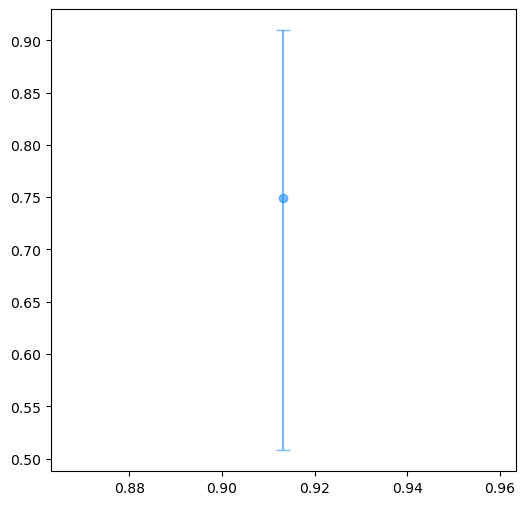

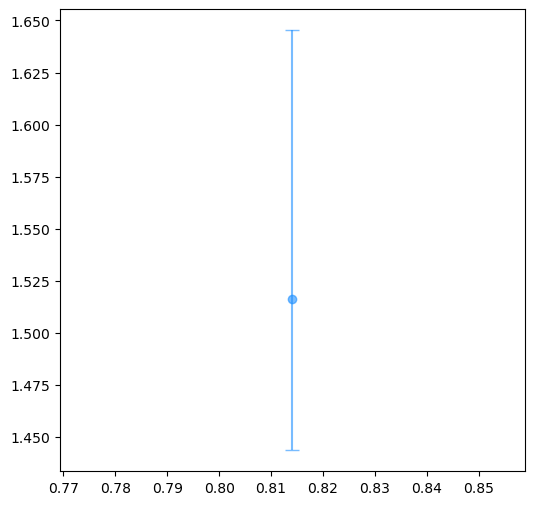

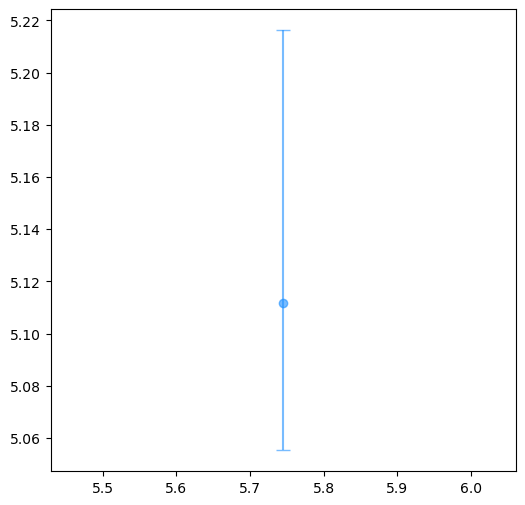

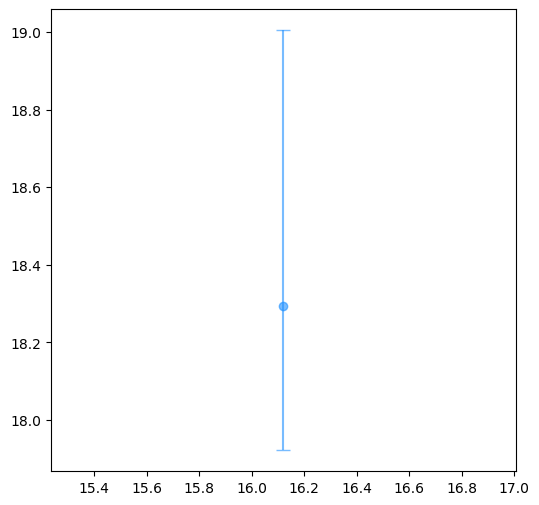

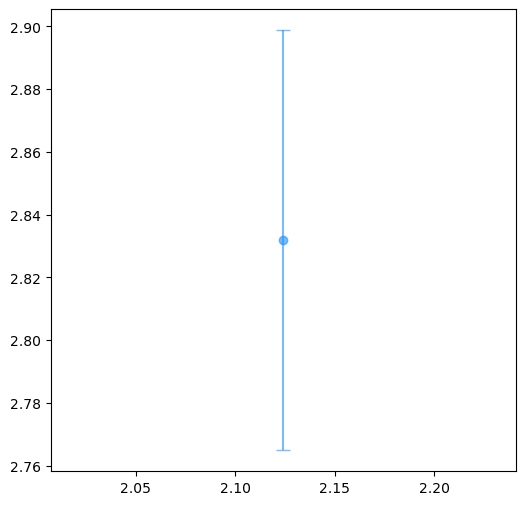

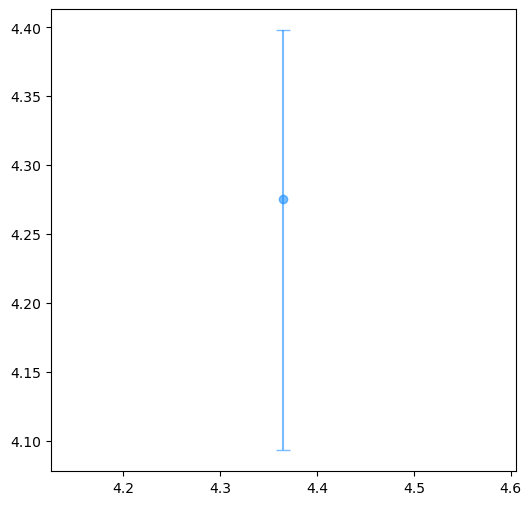

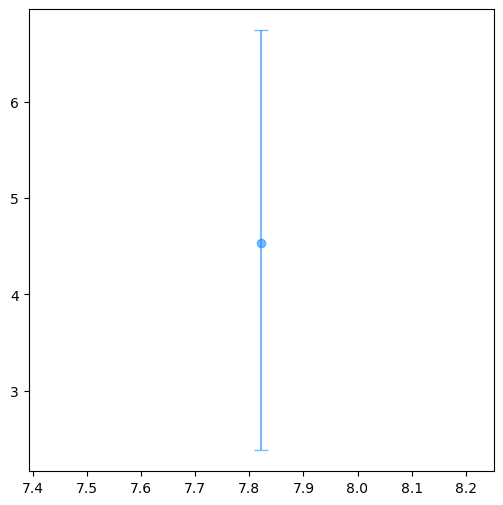

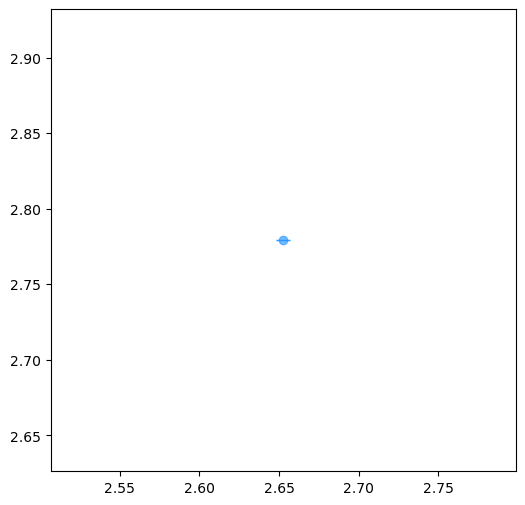

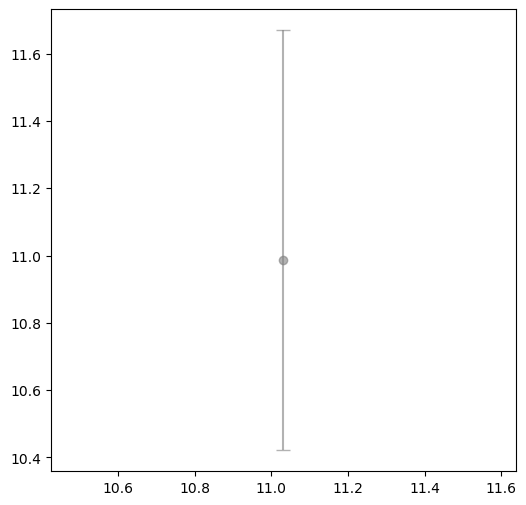

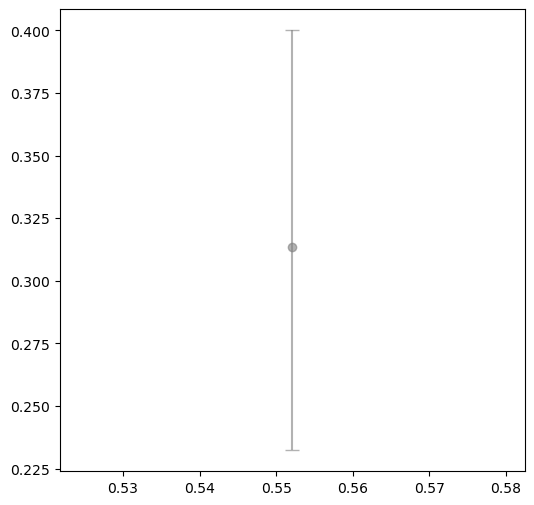

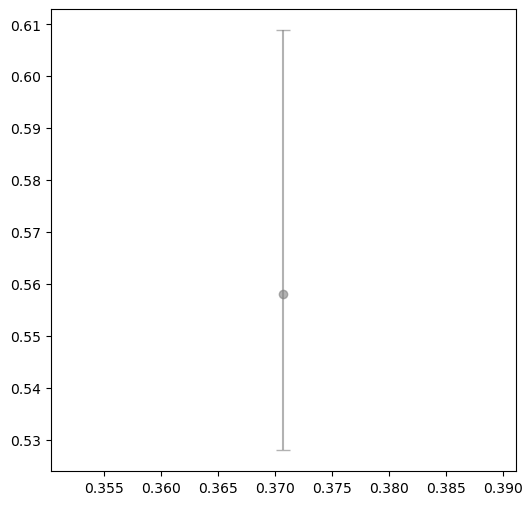

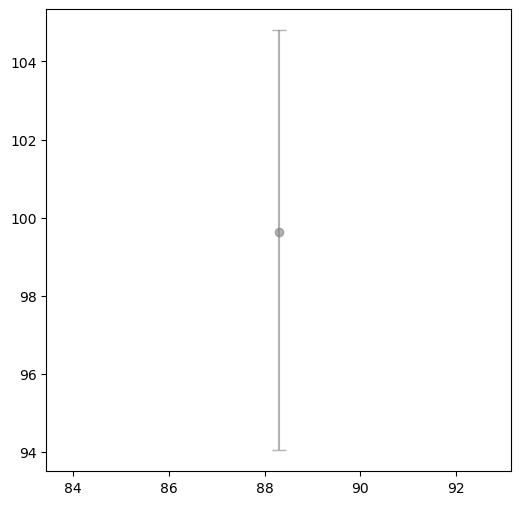

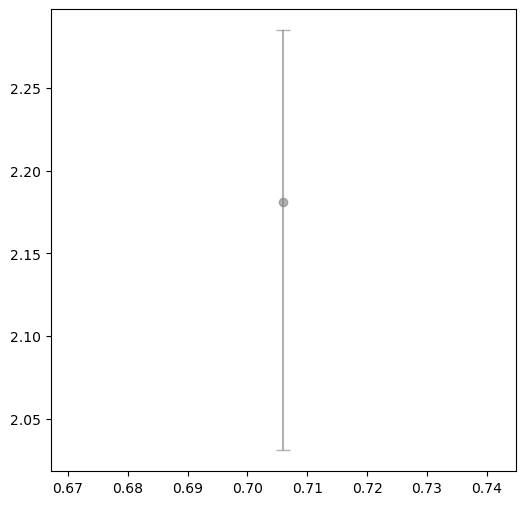

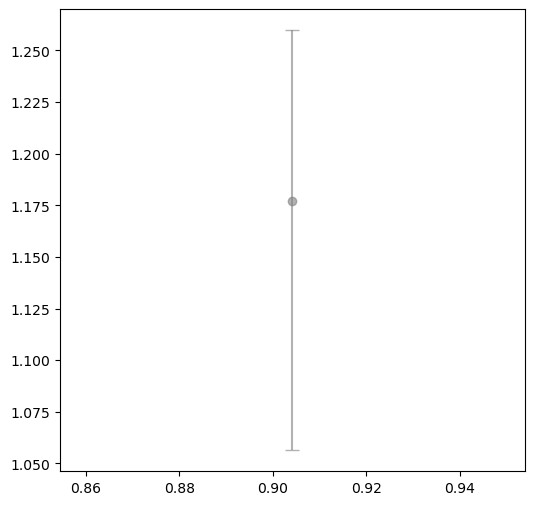

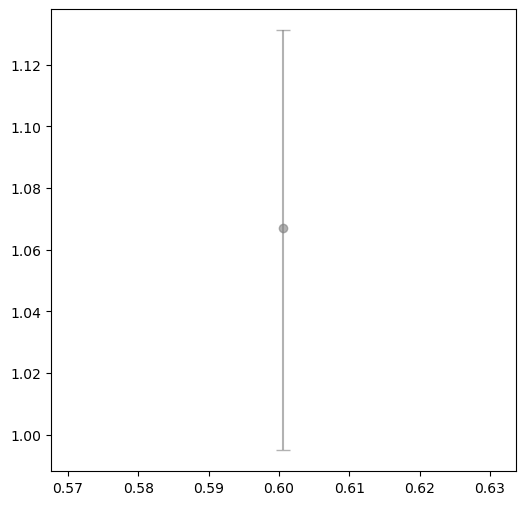

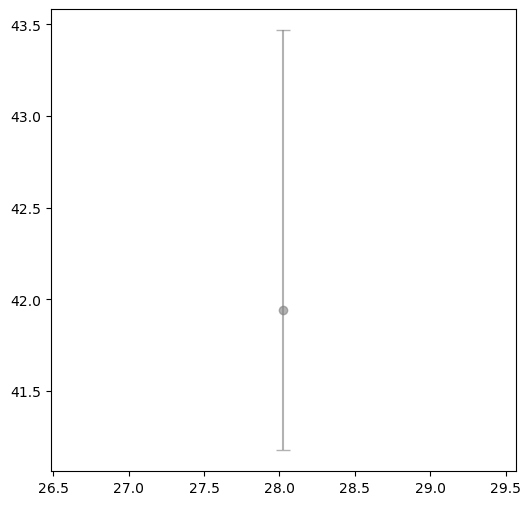

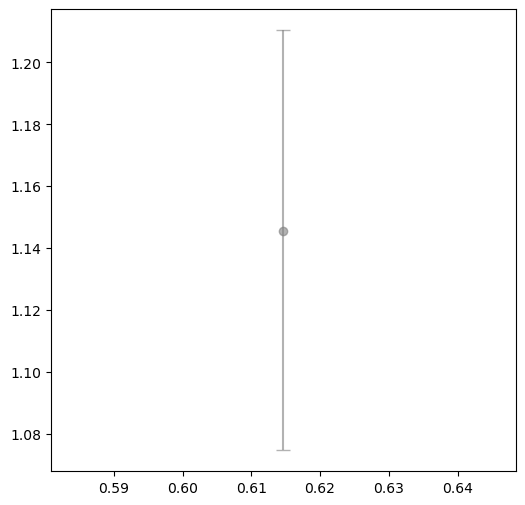

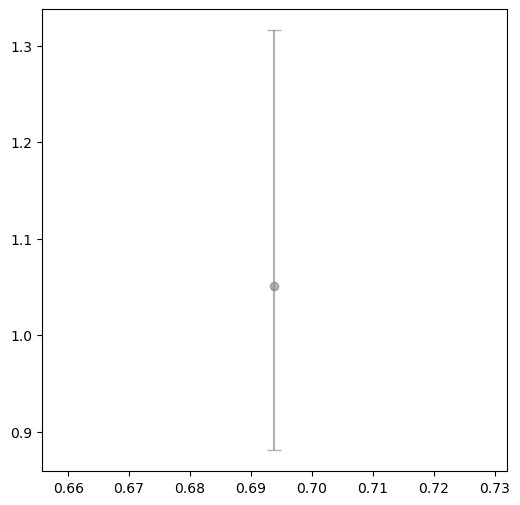

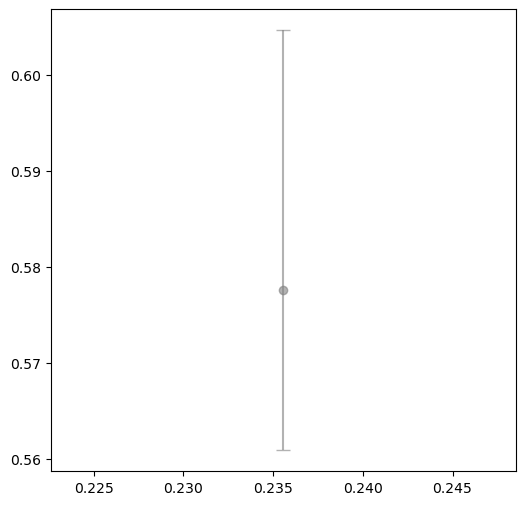

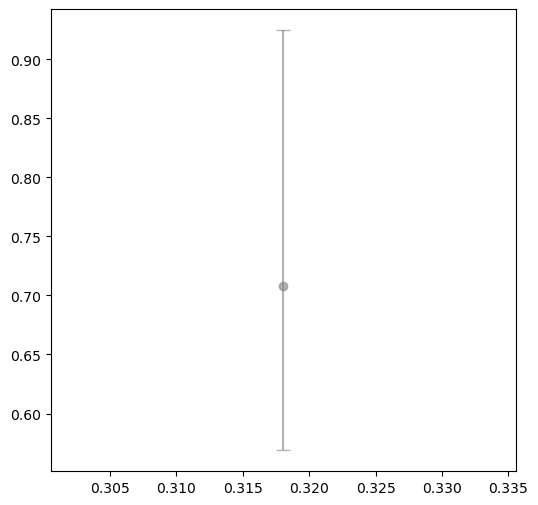

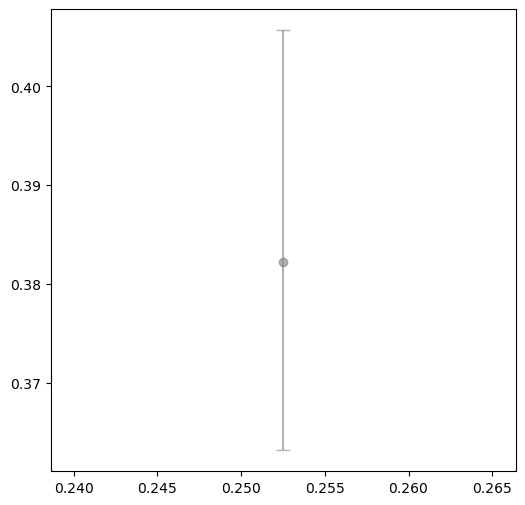

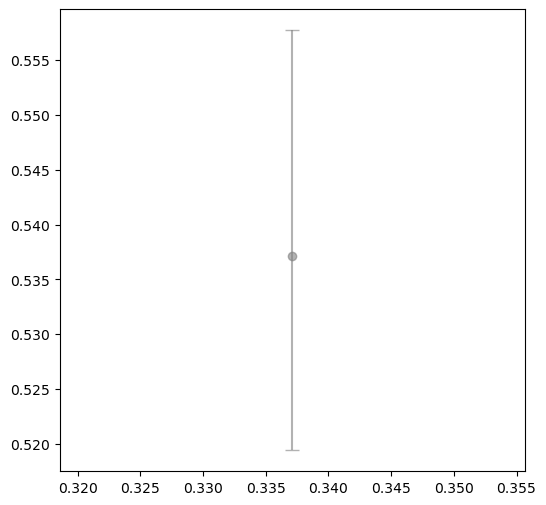

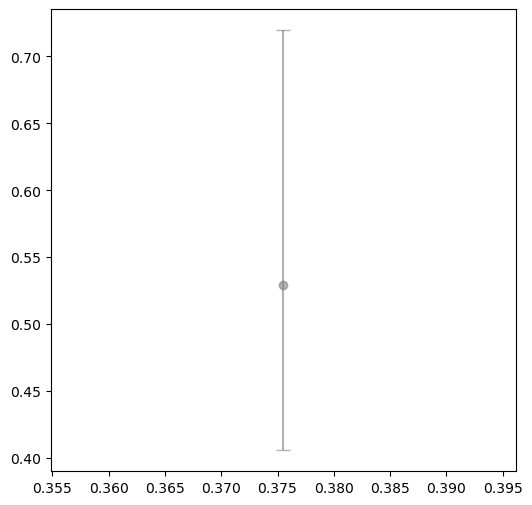

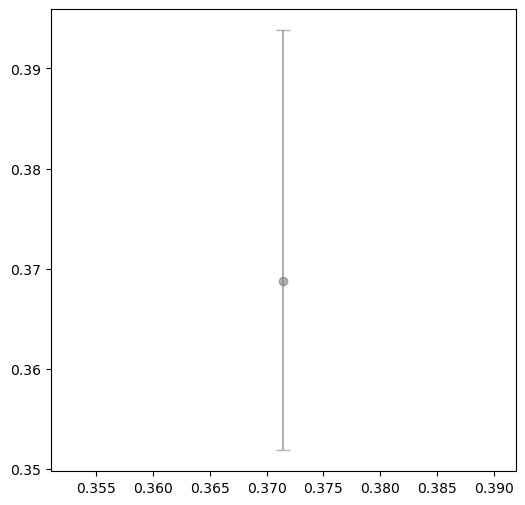

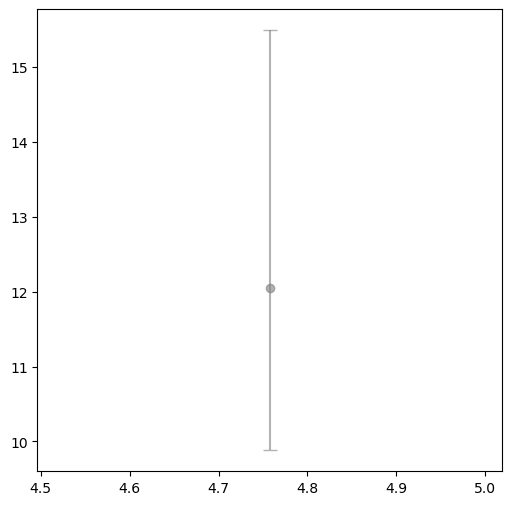

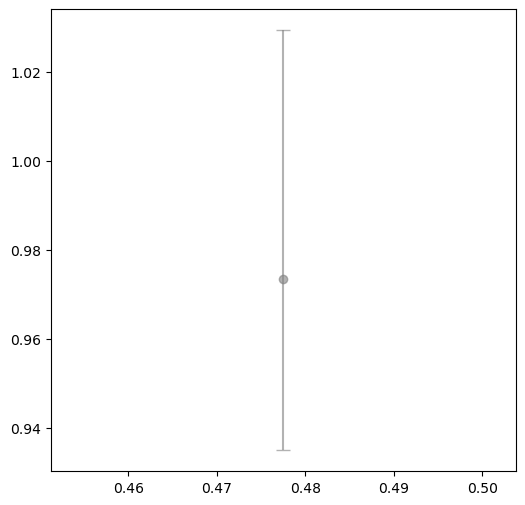

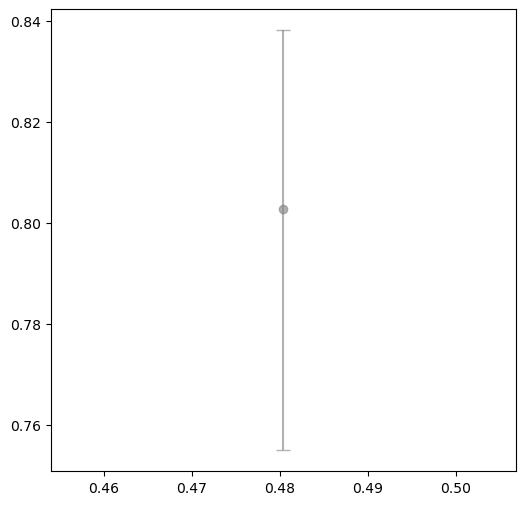

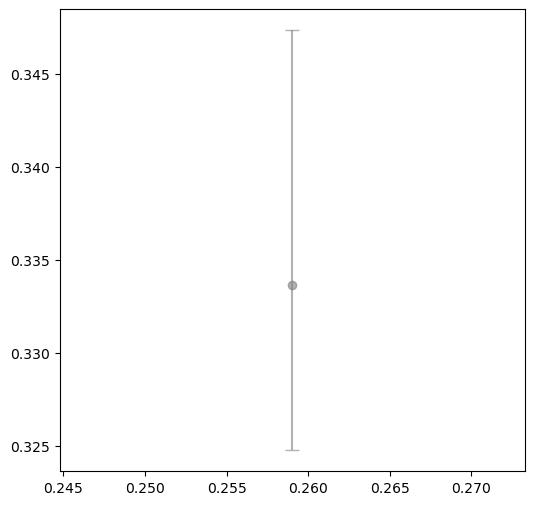

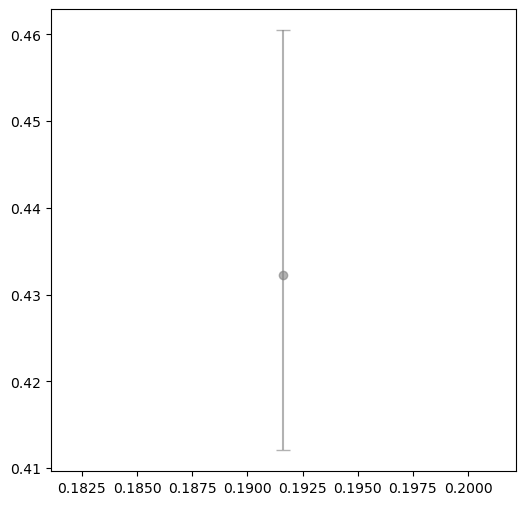

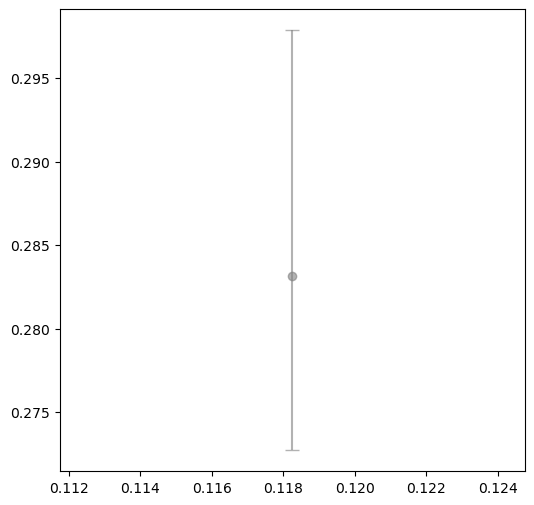

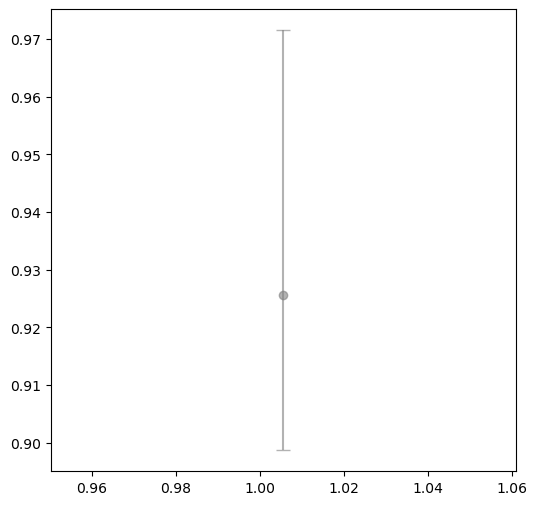

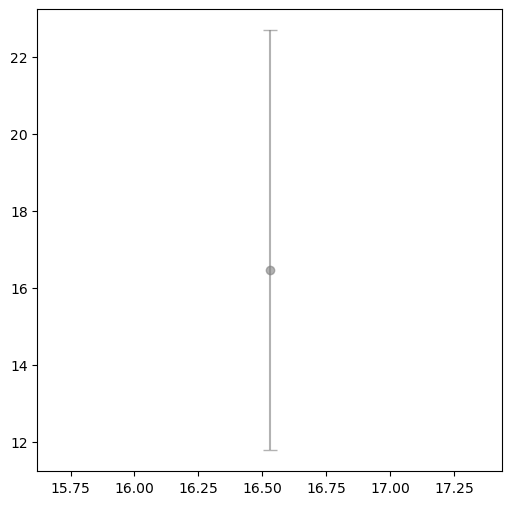

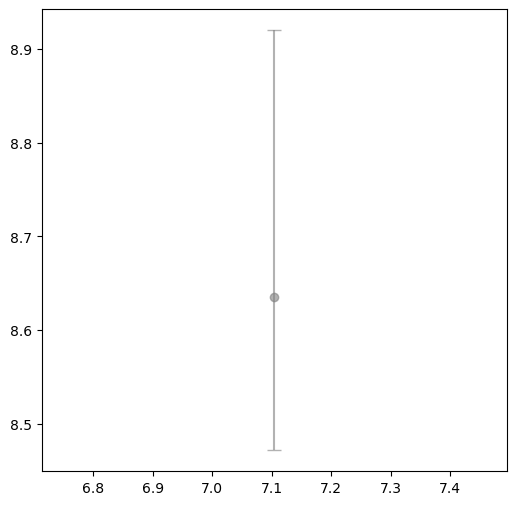

In [ ]:
for season in seasons:
    # observed values (one per station)

    # gather simulated across models
    station_vals = []
    for station in model_seasons_df['name'].unique():
        q_sim_season = model_seasons_df.loc[(model_seasons_df['season'] == season) & (model_seasons_df['name'] == station), 'q_model']
        q_obs_season = model_seasons_df.loc[(model_seasons_df['season'] == season) & (model_seasons_df['name'] == station), 'q_obs']

        #compute ensemble stats
        mean_sim = q_sim_season.mean()
        min_sim = q_sim_season.min()
        max_sim = q_sim_season.max()
        x_obs = q_obs_season.mean()  # observed value (same for all models)


        #plot with error bars
        plt.errorbar(x_obs, mean_sim,
                    yerr=[[mean_sim - min_sim], [max_sim - mean_sim]],
                    fmt='o', label=season, color=colors[season], alpha=0.6, capsize=5)
